# In-Depth: Decision Trees and Random Forests

https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

Here we'll take a look at motivating another powerful algorithm — a non-parametric algorithm called $\textbf{random forests}$. Random forests are an example of an ensemble method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting! We will see examples of this in the following sections. We begin with the standard imports:




In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings                         # Allows the code to ignore uneccessary warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


#Some code to help with visualizing
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_

            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)

            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])

    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])

    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())

    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)

    interact(fit_randomized_tree, random_state=[0, 20, 40, 60, 80, 100]);

# Motivating Random Forests: Decision Trees
Random forests are an example of an ensemble learner built on decision trees. For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

(0.0, 1.0, 0.0, 1.0)

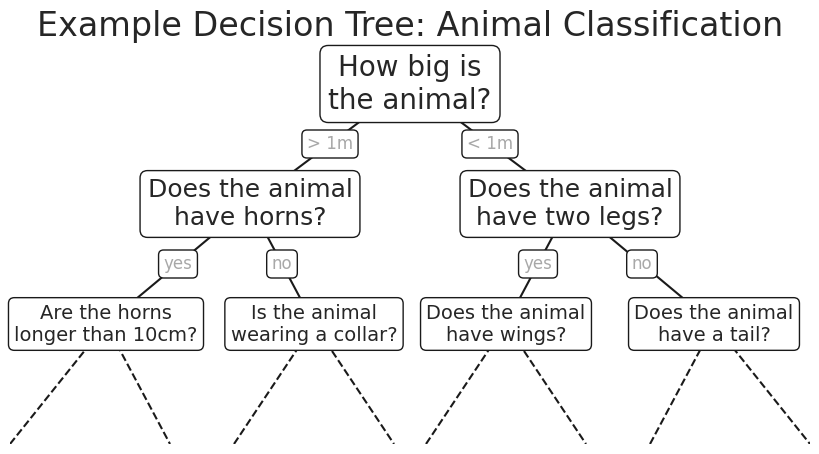

In [2]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. Let's now look at an example of this.

## Creating a decision tree
Consider the following two-dimensional data, which has one of four class labels:

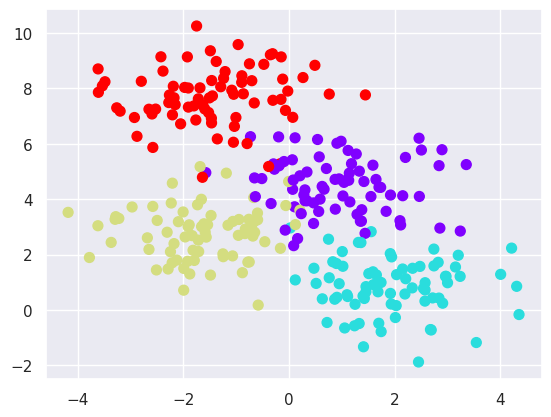

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');
#print(X.shape)
#print(y.shape)
#print(y)
#print(X[:,1])

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

## Decision Tree Levels

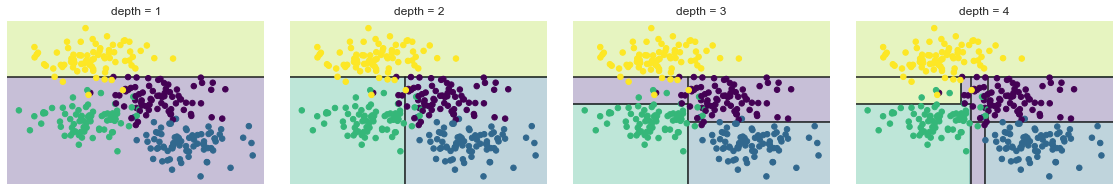

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs


fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. Except for nodes that contain all of one color, at each level every region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the DecisionTreeClassifier estimator:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)
#dir(DecisionTreeClassifier)

Let's write a quick utility function to help us visualize the output of the classifier:

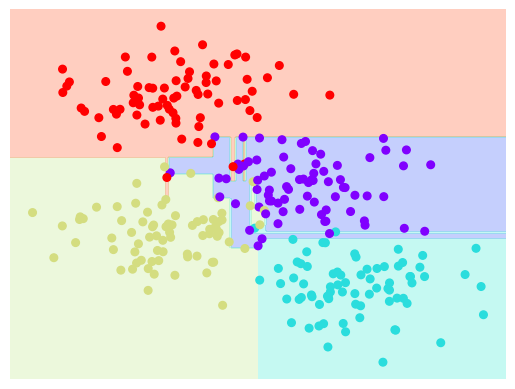

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

visualize_classifier(DecisionTreeClassifier(), X, y)

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

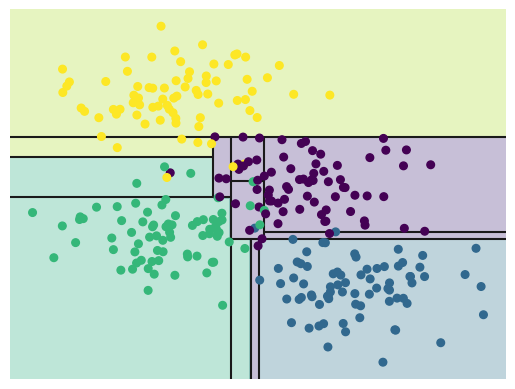

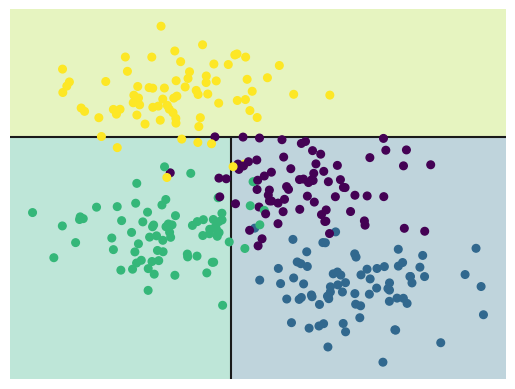

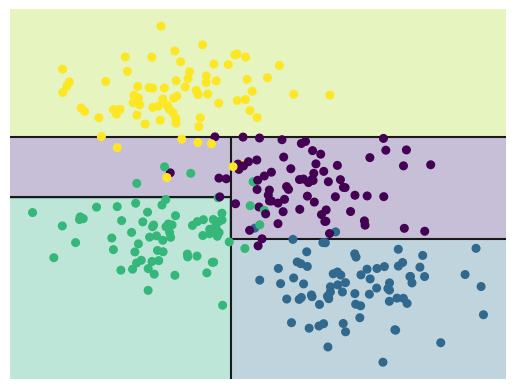

In [12]:
plot_tree_interactive(X, y);

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions. It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

# Decision trees and over-fitting
Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this over-fitting is to look at models trained on different subsets of the data

—for example, in this figure we train two different trees, each on half of the original data:

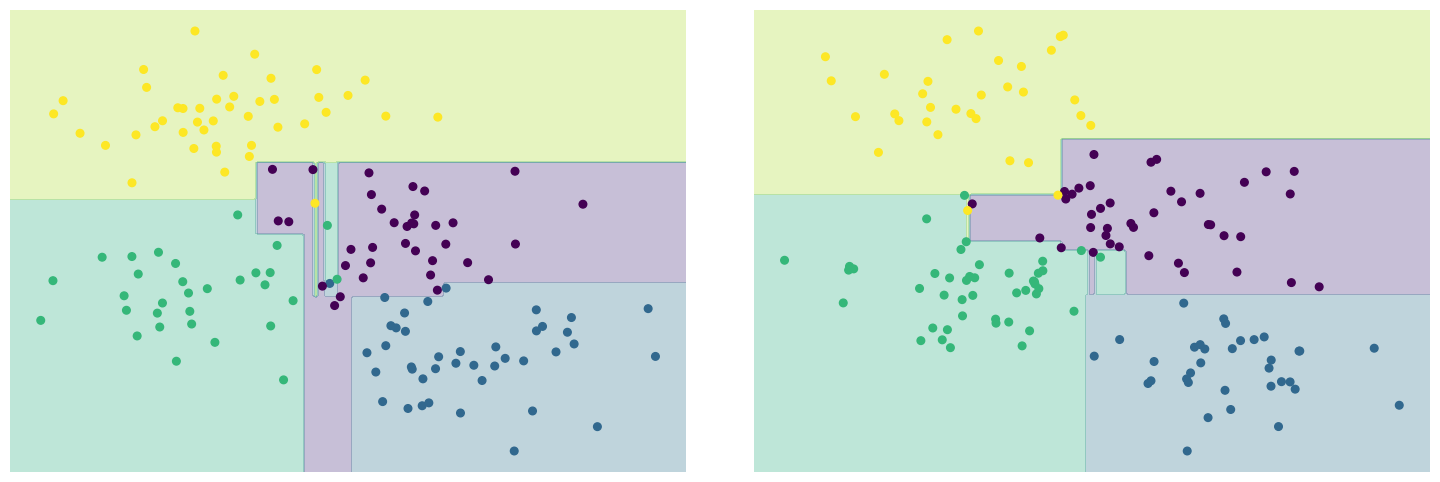

In [9]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0]) # every other element from X and y
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1]) # every odd element from X and y

# fig.savefig('figures/05.08-decision-tree-overfitting.png')

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

interactive(children=(Dropdown(description='random_state', options=(0, 20, 40, 60, 80, 100), value=0), Output(…

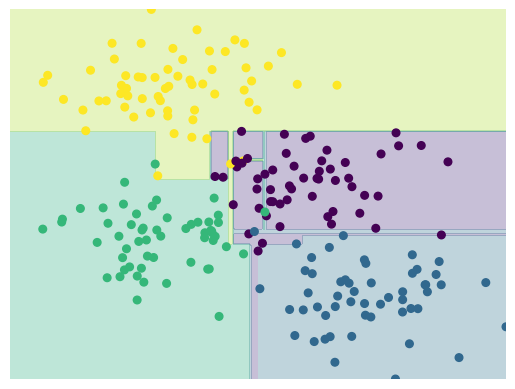

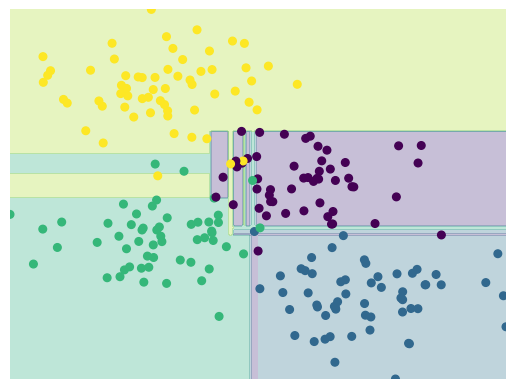

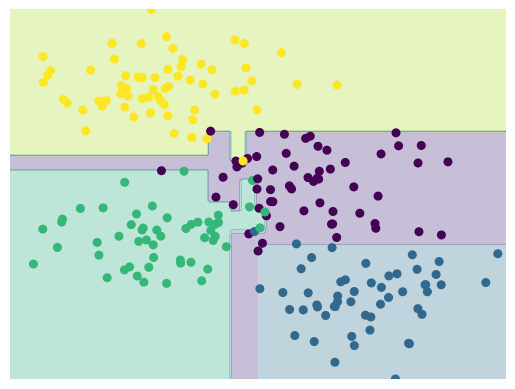

In [22]:
randomized_tree_interactive(X, y)

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.



# Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called bagging. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
$\mathbf{An\; ensemble\; of\; randomized\; decision\; trees \;is \;known \;as \;a \;random \;forest.}$

This type of bagging classification can be done manually using Scikit-Learn's BaggingClassifier meta-estimator, as shown here:


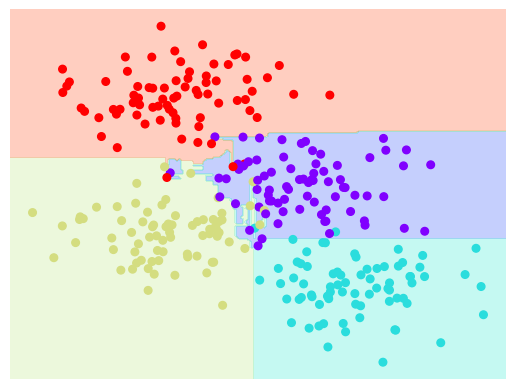

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the Scikit-Learn documentation and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

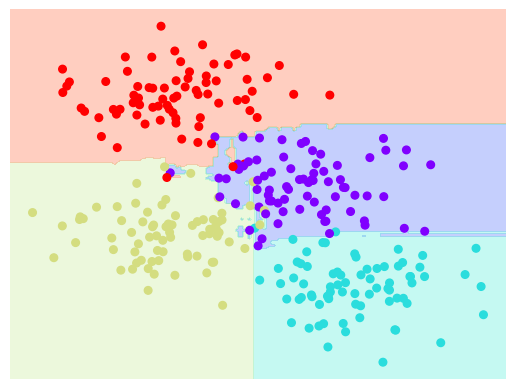

In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

# Random Forest Regression

In the previous section we considered random forests within the context of classification. Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the RandomForestRegressor, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

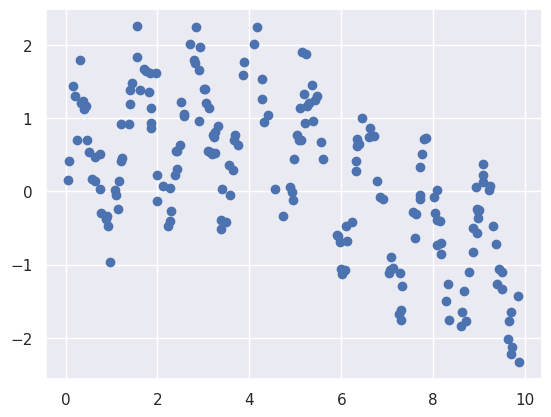

In [31]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x, sigma=0.3)
plt.scatter(x, y)
# plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

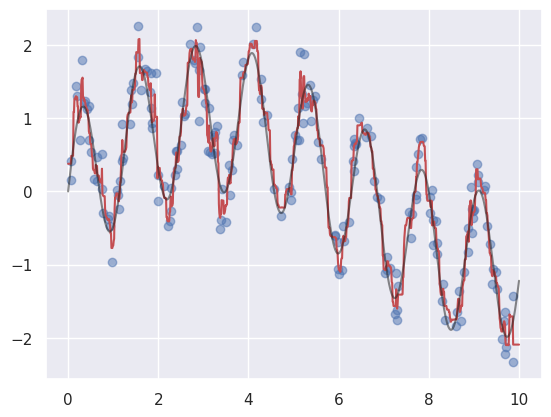

In [34]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.scatter(x, y, alpha=0.5)
# plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

# Example: Random Forest for Classifying Digits


In [43]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
print(digits.DESCR)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are di

To remind us what we're looking at, we'll visualize the first few data points:

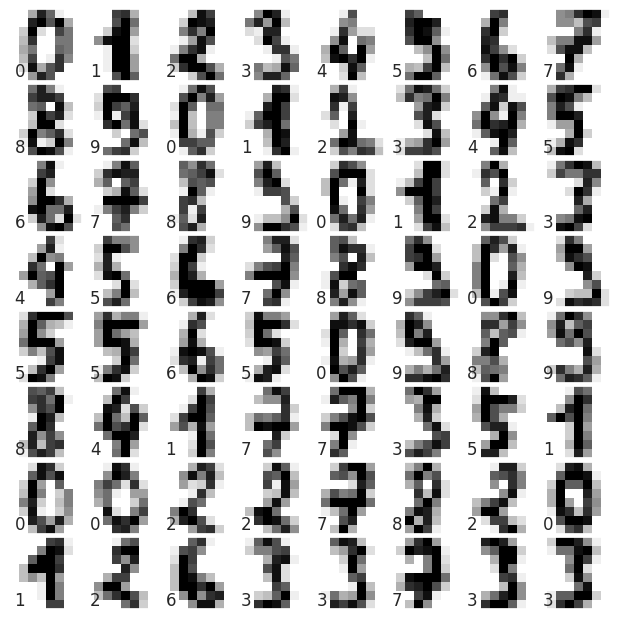

In [36]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [37]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:

In [38]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

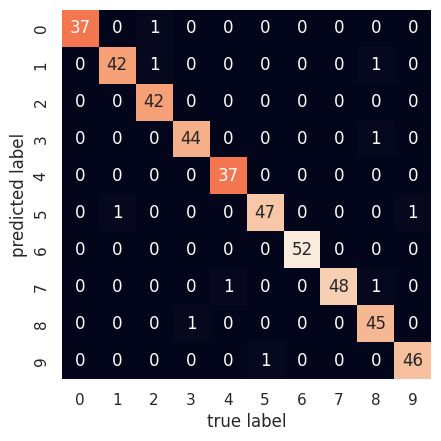

In [39]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');


We find that a simple, untuned random forest results in a very accurate classification of the digits data.

# Summary of Random Forests

This section contained a brief introduction to the concept of ensemble estimators, and in particular the random forest – an ensemble of randomized decision trees. Random forests are a powerful method with several advantages:

Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).
The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.
A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.